# Air Quality Data Hack

## Downloading data from OpenAQ

This notebook uses the OpenAQ API to download data from within a 25km radius of Leeds city centre and recorded data during 2020-2023

### Create the API query
Start by repeating the same steps as in `explore_openaq_data.ipynb` 

In [3]:
# import the necessary packages and initialise the OpenAQ client with your password
import openaq
import yaml
import pandas as pd
from ufuncs import response_to_dataframe, download_measurement_data
import os
    
# first retrieve your API key
with open("./config.yml", 'r') as ymlfile:
    API_KEY = yaml.safe_load(ymlfile)['openaq_api_key']

# initialise the OpenAQ client. This connects to the API
client = openaq.OpenAQ(api_key=API_KEY)

In [6]:
# first find the locations within 25km of Leeds
LEEDS_LATLON = (53.7953, -1.5455)

response = client.locations.list(radius=25000, coordinates=LEEDS_LATLON)
leeds_locations = response_to_dataframe(response)

print(f'There were {len(leeds_locations)} locations found within 25km of Leeds')

There were 76 locations found within 25km of Leeds


***
### Download the Leeds data
The API query returned a list of all the locations within 20km of Leeds, which we converted into a pandas DataFrame. The DataFrame's index (`id`) is a unique identifier of each station. Using these ids, we can request the data from the OpenAQ API

<div class="alert alert-block alert-warning">
<b>Warning:</b> Downloading data using the Python OpenAQ package is currently unsupported as the package is in its early stages. Instead we will use a custom function. </div>

We will use the function `download_location_data` which requires as input your `API_KEY`, and a `locations_metadata` argument, which should be the row from the `locations_df` DataFrame that corresponds to the location you wish to download the data for. Let's download data for the nearest location the `LEEDS_LATLON` first

In [7]:
# first sort locations_df by the 'distance' column so the nearest is at the top
leeds_locations = leeds_locations.sort_values('distance')

# save this dataframe as it will be useful in the next notebook
leeds_locations.to_csv('./metadata/leeds_locations.csv')

print('the first row of the dataframe is:')
print(leeds_locations.iloc[0])

the first row of the dataframe is:
name                                         SL003 - Corn Exchange Cabinet
locality                                                              None
timezone                                                     Europe/London
is_mobile                                                            False
is_monitor                                                           False
instruments                        [{'id': 3, 'name': 'PurpleAir Sensor'}]
sensors                  [{'id': 5196768, 'name': 'pressure mb', 'param...
bounds                        [-1.540428, 53.796494, -1.540428, 53.796494]
distance                                                        359.676479
country.id                                                             145
country.code                                                            GB
country.name                                                United Kingdom
owner.id                                                         

It looks like the first location in the DataFrame is a PurpleAir monitoring station from the Corn Exchange, which has an `id` of 345275

In [5]:
print(f'this station contains data for: \n {pd.json_normalize(first_row.sensors)}')

this station contains data for: 
          id                 name  ...  parameter.units parameter.display_name
0   5196767           humidity %  ...                %                      H
1   5196770        temperature f  ...                f        Temperature (F)
2   5196766  um050 particles/cm³  ...    particles/cm³            PM5.0 count
3   5196765  um005 particles/cm³  ...    particles/cm³                  PM0.5
4   1966105            pm1 µg/m³  ...            µg/m³                    PM1
5   5196764  um003 particles/cm³  ...    particles/cm³            PM0.3 count
6   1966103  um010 particles/cm³  ...    particles/cm³              PM1 count
7   1966104  um025 particles/cm³  ...    particles/cm³            PM2.5 count
8   1966102           pm25 µg/m³  ...            µg/m³                  PM2.5
9   1966107           pm10 µg/m³  ...            µg/m³                   PM10
10  1966106  um100 particles/cm³  ...    particles/cm³             PM10 count
11  5196768          pressure 

The measurement station contains data for PM0.5, PM1, PM2.5 and PM10, among other parameters.
Each parameter has an `id`, which is a number assigned to the parameter (e.g. PM10 is 1). This can be used to select which parameters to be download. We can a list of parameters and their corresponding `id` from the API:

In [6]:
parameter_map = response_to_dataframe(client.parameters.list())
print(parameter_map)

                   name  ...                                        description
id                       ...                                                   
1                  pm10  ...  Particulate matter less than 10 micrometers in...
2                  pm25  ...  Particulate matter less than 2.5 micrometers i...
3                    o3  ...                           Ozone mass concentration
4                    co  ...                 Carbon Monoxide mass concentration
5                   no2  ...                Nitrogen Dioxide mass concentration
6                   so2  ...                  Sulfur Dioxide mass concentration
7                   no2  ...                     Nitrogen Dioxide concentration
8                    co  ...                      Carbon Monoxide concentration
9                   so2  ...                       Sulfur Dioxide concentration
10                   o3  ...                                Ozone concentration
11                   bc  ...            

This shows all the possible parameters in the OpenAQ database. However, not all will be available at every location. From our chosen location (`id` = 345257), we will download PM1 and PM2.5, using the `download_measurement_data` function. The `datetime_first` and `datetime_last` fields in the metadata show that this station began reporting in May 2022. So we should be able to download the data for 2023:

downloading data for parameter id: 2
.......year: 2023 downloaded
downloading data for parameter id: 19
.......year: 2023 downloaded


<Axes: xlabel='datetime'>

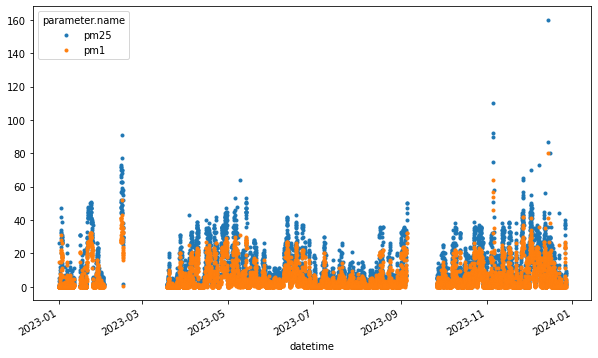

In [8]:
df = download_measurement_data(locations_id=345275, 
                               # dates in YYYY-MM-DD formats
                              date_from='2023-01-01',
                              date_to='2023-12-31',
                              parameters_id=[2,19], 
                              client=client)
# this will take a few seconds as it is downloading a year of hourly data...
df[['pm25', 'pm1']].plot(ls='', marker='.', figsize=[10,6])

A quick plot shows we've downloaded the data as expected! There are a few gaps in the data where the monitor stopped recording. As expected the PM1 concentrations are lower than PM25, as PM1 is always a subset of PM25 mass. The units are µg/m3, which can be verified by checking the metadata.

Now we can repeat this process for all the other locations with 20km of the city center. Some of the locations might have started recording after 1st January 2020, so won't have a complete timeseries, so we can filter the `leeds_locations` DataFrame to remove these:

There are only 14 locations remaining! This shows most of the low cost sensors were added to OpenAQ recently. Now we can loop over the dataframe, downloading the data and saving it to disk as csv files. Some of the stations have NO2, O3 and SO2 data, so we will include this in the download. Some of the locations have data going back to 2016, so we can include this in the download.

In [21]:
desired_parameters = [2, 19, 3, 5, 6]
for locations_id, location_metadata in leeds_locations.iterrows():

    save_path = f'./data/location_{locations_id}_data.csv'
    # check if station already downloaded
    if os.path.exists(save_path):
        print('location', locations_id, 'already downloaded')
        continue

    # check which parameters available for location
    parameters_in = [d['parameter']['id'] for d in location_metadata.sensors]
    # and make a list of the parameters which are desired AND available
    params = [p for p in parameters_in if p in desired_parameters]
    

    df = download_measurement_data(locations_id=locations_id, 
                              
                              date_from=location_metadata.loc['datetime_first.utc'],
                              date_to=location_metadata.loc['datetime_last.utc'],
                              parameters_id=params,  # including parameter ids for NO2, O3, SO2
                              client=client)

    # if data is downloaded
    if df is not None:
        df.to_csv(save_path)
        print('downloaded data for location:', locations_id)
    # sometimes no data is downloaded
    else:
        print('no data found for location:', locations_id)

location 345275 already downloaded
location 1178169 already downloaded
location 605494 already downloaded
location 1849783 already downloaded
location 2523 already downloaded
location 433460 already downloaded
location 353402 already downloaded
location 364323 already downloaded
location 299088 already downloaded
location 299249 already downloaded
location 66170 already downloaded
location 364639 already downloaded
location 1805099 already downloaded
location 2390259 already downloaded
location 299186 already downloaded
location 1117241 already downloaded
location 370575 already downloaded
location 353824 already downloaded
location 921334 already downloaded
location 1727287 already downloaded
location 1396 already downloaded
location 1145619 already downloaded
location 358633 already downloaded
location 722304 already downloaded
location 1117242 already downloaded
location 639544 already downloaded
location 1434796 already downloaded
location 363445 already downloaded
location 1567818